In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

In [201]:
import sklearn
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
bc['data'].shape

(569, 30)

In [183]:
bc['target_names']

array(['malignant', 'benign'], dtype='<U9')

Our main interest is in predicting cancer status, which is either **M**etastatic or **B**enign (column 1) from the 30 remaining measurements.

## Prepping the data
The features all have very different distributions. For example:

<AxesSubplot:ylabel='Frequency'>

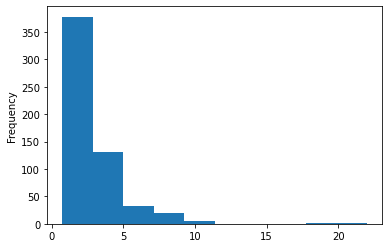

In [206]:
df.iloc[:, 12].plot.hist()

So we will first do some data preprocessing (centering and scaling):

In [208]:
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)

StandardScaler().fit_transform(X)

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

### Holdout method
First we'll explore the holdout method.

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

Already we have encountered a potential issue: in the original dataset, about 37% of cases are malignant:

In [36]:
y.mean()

0.37258347978910367

Due to randomness, the train and test sets have slightly different class balances:

In [37]:
y_train.mean(), y_test.mean()

(0.38497652582159625, 0.3356643356643357)

If we want to keep the class balance the same (or as much as possible) we can do _stratified_ resampling:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
y_train.mean(), y_test.mean()

(0.3732394366197183, 0.3706293706293706)

### Data preprocessing
Let's first scale our data:

In [210]:
from sklearn.preprocessing import StandardScaler
X_sc = StandardScaler().fit_transform(X)

Additionally, we'll project the scaled columns down to the top two PCs.

In [52]:
from sklearn.decomposition import PCA
X_2d = PCA(n_components=2).fit_transform(X_sc)

Finally, we run logistic regression to fit a model.

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_2d, y)

And let's check the model accuracy:

In [221]:
lr.score(X_test, y_test)  # ack

ValueError: X has 30 features, but LogisticRegression is expecting 2 features as input.

### Pipelining
Rather than repeating everything for both train and test, we'll package all of the data preprocessing and model transformations up into a pipeline.

In [248]:
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
)

lr = pipe.fit(X_train, y_train)

In [249]:
lr.score(X_test, y_test)

0.9912280701754386

We just observed that our test-set accuracy was 94%. However, there is some randomness here because of the resampling. 

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
pipe.fit(X_train, y_train).score(X_test, y_test)

0.972027972027972

To decrease the randomness we can employ cross-validation. 

In [260]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for (train_i, test_i) in kfold:
    sc = pipe.fit(X_train[train_i], y_train[train_i]).score(X_train[test_i], y_train[test_i])
    scores.append(sc)
    
np.mean(scores), np.std(scores)

(0.9363768115942029, 0.029723338651697864)

(This can be automated using):

In [261]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(X=X_train, y=y_train, cv=10, estimator=pipe)
scores.mean(), scores.std()

(0.9363768115942029, 0.029723338651697864)

## Learning curves
![learning curves](https://github.com/rasbt/machine-learning-book/blob/7ff5729e8c0e1fb5ce865a61ee0fac89b8f51876/ch06/figures/06_04.png?raw=True)

(Source: https://github.com/rasbt/machine-learning-book)

Let's use this simple pipeline to study the learning curve for this model:

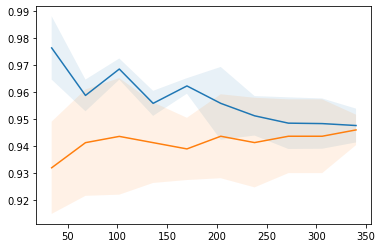

In [156]:
from sklearn.model_selection import learning_curve
train_sz, train_sc, test_sc = learning_curve(
    estimator=pipe, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1., 10)
)
for a in [train_sc, test_sc]:
    m = a.mean(1)
    s = a.std(1)
    plt.plot(train_sz, m)
    plt.fill_between(train_sz, m - s, m + s, alpha=.1)

## Tuning parameters
The learning curve suggests that the model does well after about 350 samples. For lower sample sizes, the gap between train and test is somewhat large, so we should consider regularizing.

In [264]:
pipe_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", max_iter=10_000)
)

pipe_reg.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(max_iter=10000))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=10000),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 10000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

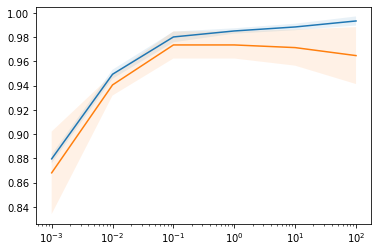

In [265]:
from sklearn.model_selection import validation_curve
param_range = np.geomspace(1e-3, 1e2, 6)
train_sc, test_sc = validation_curve(
        pipe_reg, X=X_train, y=y_train, param_name="logisticregression__C",
                param_range=param_range)
for a in [train_sc, test_sc]:
    m = a.mean(1)
    s = a.std(1)
    plt.plot(param_range, m)
    plt.fill_between(param_range, m - s, m + s, alpha=.1)
plt.xscale('log')